# Projet P4 - Anticipez les besoins en consommation de bâtiments
*OPENCLASSROOMS - Parcours Data Scientist - Adeline Le Ray - 12/2023*
<hr>

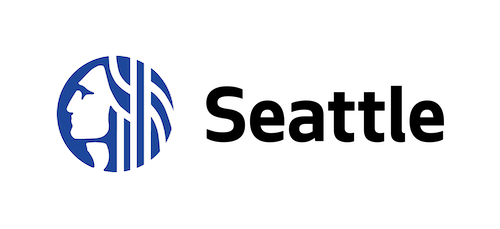

## <font color='#46abe6'>Notebook 3 - Prédiction des émissions de CO2 'TotalGHGEmissions'</font>

<span style='background:#46abe6'><span style='color:white'>**Notebook 3_1 - Sélection du modèle**</span></span>

[Partie 1 - Importation des librairies et des données](#partie_1)

[Partie 2 - Sélection du meilleur modèle](#partie_2)

<span style='background:#d5155b'><span style='color:white'>**Notebook 3_2 - Optimisation du modèle**</span></span>

[Partie 3 - Optimisation du meilleur modèle](#partie_3)
* [3.1. Optimisation du modèle](#3_1)
* [3.2. Analyse des résidus](#3_2)

[Partie 4 - Feature importance globale et locale](#partie_4)
* [4.1. Feature importance globale](#4_1)
* [4.2. Feature importance locale](#4_2)
* [4.3. Conclusion](#4_3)

<span style='background:#46abe6'><span style='color:white'>**Notebook 3_3 - Evaluation de l'influence de EnergyStarScore**</span></span>

[Partie 5 - Evaluation de l'influence de EnergyStarScore](#partie_5)

# <font color='#0a389f'>Importation des librairies et des données<a class="anchor" id="partie_1"></a></font>

## <font color='#46abe6'>Importation des librairies<a class="anchor" id="1_1"></a></font>

In [1]:
import numpy as np
import pandas as pd

# graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# affichage Markdown des Outputs
from IPython.display import Markdown 

# Encodeur pour les variables catégorielles
from sklearn.preprocessing import OneHotEncoder, TargetEncoder

# Standardisation des variables
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Split entraînement /test
from sklearn.model_selection import train_test_split

# Cross validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer

# Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Métriques Evaluation du modèle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

import time

import scipy.stats as st

# Feature importance
import shap

import pickle

In [2]:
# Version python
!python --version
# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.11.4
numpy - 1.24.0
pandas - 2.1.1
seaborn - 0.13.0
shap - 0.44.1


In [3]:
# Paramètres par défauts des graphiques
sns.set_style('whitegrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
width = 7
height = 5
plt.figure(figsize=(width, height))
meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}

<Figure size 700x500 with 0 Axes>

In [4]:
# Initialisation de shap 
shap.initjs()

In [5]:
# Options d'affichage : toutes les colonnes et contenu complet de la colonne
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## <font color='#46abe6'>Définition des fonctions<a class="anchor" id="1_2"></a></font>

In [6]:
def create_preprocessor(encoder, scaler, num_col, cat_col):
    """!
    @brief Crée un preprocesseur pour les données numériques et catégorielles.

    Cette fonction crée un preprocesseur qui applique les transformations spécifiées aux colonnes 
    numériques et catégorielles.

    @param encoder: Encoder pour encoder les variables catégorielles (type : Encoder).
    @param scaler: Scaler pour mettre à l'échelle les variables numériques (type : Scaler).
    @param num_col: Liste des noms des colonnes numériques (type : list[str]).
    @param cat_col: Liste des noms des colonnes catégorielles (type : list[str]).
    
    @return preprocessor: Preprocesseur pour les données numériques et catégorielles (type : ColumnTransformer).
    """
    
    # Columns: num_transformer = scaler, cat_transformer = encoder
    num_transformer = make_pipeline(scaler)
    cat_transformer = make_pipeline(encoder)

    # Associer encoder et scaler avec ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[('num', num_transformer, num_col),
                      ('cat', cat_transformer, cat_col)])

    
    return preprocessor

In [7]:
def search_best_params(pipe, param_grid, X_train, y_train, search_cv='GridSearchCV', score='r2', cv=5):
    """!
    @brief Recherche les meilleurs hyperparamètres pour un pipeline de modèle.

    Cette fonction utilise une recherche de grille ou une recherche aléatoire pour trouver les meilleurs hyperparamètres
    pour un pipeline de modèle donné.

    @param pipe: Pipeline de modèle à optimiser (type : sklearn.pipeline.Pipeline).
    @param param_grid: Grille des hyperparamètres à rechercher (type : dict).
    @param X_train: Features d'entraînement (type : array-like).
    @param y_train: Target d'entraînement (type : array-like).
    @param search_cv: Type de recherche à effectuer ('GridSearchCV' ou 'RandomizedSearchCV') (type : str, valeur par défaut : 'GridSearchCV').
    @param score: La métrique de score à utiliser pour l'optimisation (type : str, valeur par défaut : 'r2').
    @param cv: Le nombre de fold de validation croisée à utiliser (type : int, valeur par défaut : 5).
    
    @return best_model: Le meilleur modèle trouvé après l'optimisation des hyperparamètres (type : sklearn.pipeline.Pipeline).
    @return best_params_: Les meilleurs hyperparamètres trouvés (type : dict ou 'NA' si aucune recherche n'est effectuée).
    """
    
    if param_grid:
        # Recherche les meilleurs hyperparamètres par validation croisée
        if search_cv == 'GridSearchCV':
            grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring=score, n_jobs=-1)
        elif search_cv == 'RandomizedSearchCV':
            grid_search = RandomizedSearchCV(pipe, param_grid, cv=cv, scoring=score, n_jobs=-1)

        grid_search.fit(X_train, y_train)
        best_params_ = grid_search.best_params_
        best_model = grid_search.best_estimator_
    else:
        # Si le modèle n'a pas d'hyperparamètres, considère pipe comme best_model
        best_model = pipe
        best_params_ = 'NA'

    return best_model, best_params_

In [8]:
def evaluate_model(model, X_train, y_train, X_test, y_test, score='r2', cv=5):
    """!
    @brief Évalue les performances d'un modèle.

    Cette fonction évalue les performances d'un modèle en effectuant une validation croisée,
    en calculant plusieurs métriques de performance sur l'ensemble de test et en fournissant des informations
    sur le temps d'entraînement et de prédiction.

    @param model: Modèle à évaluer (type : sklearn.base.BaseEstimator).
    @param X_train: Features d'entraînement (type : array-like).
    @param y_train: Target d'entraînement (type : array-like).
    @param X_test: Features de test (type : array-like).
    @param y_test: Target de test (type : array-like).
    @param score: La métrique de score à utiliser pour l'évaluation (type : str, valeur par défaut : 'r2').
    @param cv: Le nombre de folds de validation croisée à utiliser (type : int, valeur par défaut : 5).
    
    @return results: Dictionnaire contenant les résultats de l'évaluation du modèle (type : dict).
    """    
    # Cross-validation sur le training set
    scores = cross_validate(model, X_train, y_train, scoring=score, cv=cv)
    cv_r2 = scores['test_score'].mean()
    cv_std = np.std(scores['test_score'])

    # Prédiction et scores 
    start_time = time.perf_counter() # début compteur pour les temps d'exécution du modèle
    model.fit(X_train, y_train) # Entraînement du modèle
    fit_time = time.perf_counter() # compteur entraînement
    y_pred = model.predict(X_test) # Prédiction 
    pred_time = time.perf_counter() # compteur prédiction
    y_pred_train = model.predict(X_train) # prédiction de y_train
       
    # Dictionnaire contenant tous les résultats
    results = {
        'cv_r2': cv_r2,
        'cv_std': cv_std,
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': root_mean_squared_error(y_test, y_pred),
        'fit_time': fit_time - start_time,
        'pred_time': pred_time - fit_time,
        'y_pred': y_pred,  
        'model': model  
    }

    return results

In [9]:
def optimize_model(model, 
                  encoder, 
                  scaler, 
                  param_grid, 
                  X_train, y_train, 
                  X_test, y_test, 
                  cat_col, num_col, 
                  score='r2', cv=5):
    """!
    @brief Optimise un modèle de régression en utilisant une recherche d'hyperparamètres et évalue ses performances.

    Cette fonction réalise les étapes suivantes :
    1. Crée un pipeline avec le préprocesseur et le modèle donnés.
    2. Recherche les meilleurs hyperparamètres du modèle à l'aide de GridSearchCV et RandomizedSearchCV.
    3. Évalue les performances du modèle avec les meilleurs hyperparamètres sur l'ensemble d'entraînement et de test.

    @param model: Modèle à entraîner et évaluer (type : sklearn.base.BaseEstimator).
    @param encoder: Encoder pour encoder les variables catégorielles (type : Encoder).
    @param scaler: Scaler pour mettre à l'échelle les variables numériques (type : Scaler).
    @param param_grid: Grille des hyperparamètres à rechercher (type : dict).
    @param X_train: Features d'entraînement (type : array-like).
    @param y_train: Target d'entraînement (type : array-like).
    @param X_test: Features de test (type : array-like).
    @param y_test: Target de test (type : array-like).
    @param cat_col: Liste des noms des colonnes catégorielles (type : list[str]).
    @param num_col: Liste des noms des colonnes numériques (type : list[str]).
    @param score: Métrique de score à utiliser pour l'évaluation (type : str, valeur par défaut : 'r2').
    @param cv: Nombre de folds de validation croisée à utiliser (type : int, valeur par défaut : 5).
    
    @return best_model_: Le meilleur modèle trouvé après l'optimisation des hyperparamètres (type : sklearn.pipeline.Pipeline).
    @return best_params_: Les meilleurs hyperparamètres trouvés (type : dict).
    @return y_pred: Les valeurs prédites sur le dataset de test avec le meilleur modèle (type : array-like).
    """
    # Initialisation du dataframe de résultats
    cv_eval_df = pd.DataFrame()
    
    # Initialisation dictionnaire pour stocker les meilleurs modèles et paramètres
    best_models = {}
    
    # Créer le pipeline
    preprocessor = create_preprocessor(encoder, scaler, num_col, cat_col)
    pipe = make_pipeline(preprocessor, model)
       
    # Recherche des meilleurs hyperparamètres par GridSearchCV et RandomizedSearchCV puis évaluation du modèle
    for search_cv in ['GridSearchCV', 'RandomizedSearchCV'] : 
        # Recherche du meilleur modèle
        best_model, best_params_ = search_best_params(pipe, 
                                                  param_grid, 
                                                  X_train, y_train, 
                                                  search_cv=search_cv, 
                                                  score=score, cv=cv)
             
        # Évaluation du modèle
        results = evaluate_model(best_model, X_train, y_train, X_test, y_test, score='r2', cv=5)
        
        # Stocker les meilleurs modèles, paramètres et les résidus dans le dictionnaire
        best_models[search_cv] = {'best_model': results['model'], 
                                  'best_params': best_params_, 
                                  'y_pred' : results['y_pred']}
        
        best_params = {key.replace('gradientboostingregressor__', ''): value for key, value in best_params_.items()}
        
        # Cross-validation et scores sur le testing test : ajout à eval_df
        new_row = pd.DataFrame({'Model': str(model),
                                'SearchCV' : str(search_cv),
                                'Parameters': str(best_params),
                                'CV_R2 score': "{:.3f} (+/- {:.03f})".format(results['cv_r2'], results['cv_std']),
                                'Train_R2 score': round(results['train_r2'], 3),
                                'Test_R2 score': round(results['test_r2'], 3),
                                'Test_MAE': round(results['MAE'], 3),
                                'Test_RMSE': round(results['RMSE'], 3),
                                'Fit Time (s)': round(results['fit_time'], 3),
                                'Prediction Time (s)': round(results['pred_time'], 3)
                                }, index=[0])

        # Ajouter la nouvelle ligne à eval_df
        cv_eval_df = pd.concat([cv_eval_df, new_row],ignore_index=True)
        
    # Afficher le dataframe résultat
    print(f"Combinaison Encoder: {encoder}, Scaler: {scaler}, Model : {model}")
    mask = (cv_eval_df['Model'] == str(model))
    display(cv_eval_df[mask])
    
    # Récupérer les best_params_ du modèle ayant obtenu le meilleur Test_R2 score 
        
    if (cv_eval_df.loc[mask&(cv_eval_df['SearchCV'] == 'GridSearchCV'), 'Test_R2 score'].values >=
        cv_eval_df.loc[mask&(cv_eval_df['SearchCV'] == 'RandomizedSearchCV'), 'Test_R2 score'].values):
        
        best_model_ = best_models['GridSearchCV']['best_model']
        best_params_ = best_models['GridSearchCV']['best_params']
        y_pred = best_models['GridSearchCV']['y_pred']
        best_results = cv_eval_df[cv_eval_df['SearchCV']=='GridSearchCV'].drop(columns='SearchCV')
        print('Le meilleur modèle est obtenu avec GridSearchCV.')
    
    else:
        
        best_model_ = best_models['RandomizedSearchCV']['best_model']
        best_params_ = best_models['RandomizedSearchCV']['best_params']
        y_pred = best_models['RandomizedSearchCV']['y_pred']
        best_results = cv_eval_df[cv_eval_df['SearchCV']=='RandomizedSearchCV'].drop(columns='SearchCV')
        print('Le meilleur modèle est obtenu avec RandomizedSearchCV.')
    
    return best_model_, best_params_, y_pred, best_results

In [10]:
def plot_metrics_comparison(df, comparison_feature, title, legend_bbox_to_anchor=(1, 1)):
    """!
    @brief Affiche des diagrammes à barres pour comparer les modèles sur différentes métriques.

    Cette fonction prend un DataFrame contenant les résultats des modèles pour une comparaison spécifique
    et affiche des diagrammes à barres pour chaque métrique spécifiée.

    @param df: DataFrame contenant les résultats des modèles pour une comparaison spécifique (type : pd.DataFrame).
    @param comparison_feature: Nom du test ou de la condition comparé (type : str).
    @param title: Titre du graphique (type : str).
    @param legend_bbox_to_anchor: Position de la légende en termes de coordonnées de la boîte englobante (type : tuple, valeur par défaut : (1, 1)).
    """
    metrics=['Train_R2 score', 'Test_R2 score','Test_MAE', 'Test_RMSE', 'Fit Time (s)', 'Prediction Time (s)']
    
    # Affichage de diagrammes à barres pour comparer les modèles 
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), tight_layout=True)
    axes = axes.flatten()  # liste plate pour itération
    fig.suptitle(title, wrap=True, fontsize=24)

    # un graphique par métrique
    for i, metric in enumerate(metrics):
        plot_data = df[[comparison_feature, metric]].melt(id_vars=[comparison_feature], var_name='Metrics', value_name='Value')
        ax = sns.barplot(data=plot_data, x='Metrics', y='Value', hue=comparison_feature, palette='viridis', ax=axes[i])
        ax.set_title(f'{metric}')
        ax.get_legend().remove()
        
        for bars in ax.containers:
            ax.bar_label(bars, fontsize=15)

    # Afficher la légende avec bbox_to_anchor
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=legend_bbox_to_anchor)
    plt.show()

In [11]:
def plot_residuals_distribution(y_test, y_pred):
    """!
    @brief Trace plusieurs visualisations des résidus.

    Cette fonction affiche plusieurs visualisations des résidus entre les valeurs cibles réelles et 
    les valeurs prédites par un modèle de régression.

    @param y_test: Les valeurs cibles réelles (type : array-like).
    @param y_pred: Les valeurs prédites par le modèle (type : array-like).  
    """
    
    # Résidus et résidus standards
    residuals = y_test - y_pred
    residus_std = residuals / np.sqrt(sum(residuals**2) / (len(residuals) - 1))

    # Boxplot des résidus
    fig, ax = plt.subplots(2, 2, figsize=(20, 15), tight_layout=True)
    sns.boxplot(x=residus_std, ax=ax[0, 0])
    ax[0, 0].set_title('Boxplot des résidus standards')
    ax[0, 0].set_xlabel("Résidus standards")
    
    # Distribution des résidus et normalité
    sns.histplot(x=residus_std, ax=ax[0, 1], kde=True)
    ax[0, 1].set_title('Distribution des résidus standards')
    ax[0, 1].set_xlabel("Résidus standards") 

    # Diagramme Quantile Quantile
    st.probplot(residus_std, dist='norm', plot=ax[1, 0])
    ax[1, 0].set_title('Normal Q-Q plot')

    # y_pred vs y_test
    y_plot = [y_test.min(), y_test.max()]
    ax[1, 1] = sns.scatterplot(x=y_test, y=y_pred)
    ax[1, 1].set(xlabel='y_test', ylabel='y_pred')
    ax[1, 1].plot(y_plot, y_plot, color='r')
    ax[1, 1].set_title('y_pred vs y_test')

    plt.show()

## <font color='#46abe6'>Importation des données<a class="anchor" id="1_3"></a></font>

In [12]:
# Importation du dataframe nettoyé
building_data = pd.read_pickle('data_afterEDA.pkl')

In [13]:
# Datasets d'entraînement et de test
X_train, X_test, y_train, y_test = pickle.load(open('train_test_CO2.pkl', 'rb'))

In [14]:
# Meilleure combinaison Encoder, Scaler, Model
best_combination = pickle.load(open('best_combination_CO2.pkl', 'rb'))

In [15]:
# Définition des variables à encoder et standardiser
cat_col = ['Neighborhood', 
           'PrimaryPropertyType']

num_col = X_train.columns.difference(cat_col).to_list()

# <font color='#0a389f'>Partie 3 - Optimisation du meilleur modèle<a class="anchor" id="partie3"></a></font>

Nous allons maintenant optimiser le modèle sélectionné pour obtenir les meilleurs hyperparamètres. Comme pour la sélection du modèle, la méthode utilisée sera la validation croisée : 
- **GridSearchCV** : Recherche systématique des meilleures combinaisons d'hyperparamètres en évaluant chaque combinaison dans une grille prédéfinie.
- **RandomizedSearchCV** : Exploration efficace de l'espace des hyperparamètres en sélectionnant aléatoirement un sous-ensemble de combinaisons à partir d'une distribution donnée.

## <font color='#46abe6'>3.1. Optimisation du modèle<a class="anchor" id="3_1"></a></font>

In [16]:
# Initialisation du dataframe de résultats
cv_eval_df = pd.DataFrame()

In [17]:
# Modèle sélectionné dans le notebook 2_1
display(best_combination)

,Value
Encoder,OneHotEncoder()
Scaler,StandardScaler()
Model,GradientBoostingRegressor()
Parameters,{'gradientboostingregressor__n_estimators': 100}
CV_R2 score,0.780 (+/- 0.021)
Train_R2 score,0.868
Test_R2 score,0.805
Test_MAE,0.205
Test_RMSE,0.28
Fit Time (s),0.38737


In [18]:
%%time
# Optimisation du GradientBoostingRegressor par validation croisée
encoder = best_combination.T['Encoder'].iloc[0]
scaler = best_combination.T['Scaler'].iloc[0]
model = GradientBoostingRegressor()
param_grid = {'gradientboostingregressor__n_estimators':[50, 100, 150],
              'gradientboostingregressor__learning_rate':[0.05, 0.10, 0.15],
              'gradientboostingregressor__max_depth':[2, 3, 4], 
              'gradientboostingregressor__min_samples_split' : [2, 3, 4]}

best_gbr, gbr_best_params, gbr_y_pred, gbr_results = optimize_model(model=model,
                                                                    encoder=encoder,
                                                                    scaler=scaler,
                                                                    param_grid=param_grid,
                                                                    X_train=X_train, y_train=y_train,
                                                                    X_test=X_test, y_test=y_test,
                                                                    cat_col=cat_col, num_col=num_col,
                                                                    score='r2', cv=5)

Combinaison Encoder: OneHotEncoder(), Scaler: StandardScaler(), Model : GradientBoostingRegressor()


,Model,SearchCV,Parameters,CV_R2 score,Train_R2 score,Test_R2 score,Test_MAE,Test_RMSE,Fit Time (s),Prediction Time (s)
0,GradientBoostingRegressor(),GridSearchCV,"{'learning_rate': 0.05, 'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 150}",0.786 (+/- 0.019),0.894,0.800,0.208,0.284,0.317,0.004
1,GradientBoostingRegressor(),RandomizedSearchCV,"{'n_estimators': 150, 'min_samples_split': 3, 'max_depth': 4, 'learning_rate': 0.05}",0.786 (+/- 0.018),0.894,0.799,0.208,0.284,0.328,0.004


Le meilleur modèle est obtenu avec GridSearchCV.
CPU times: total: 5.39 s
Wall time: 14.8 s


In [19]:
metrics=['Model', 'Train_R2 score', 'Test_R2 score','Test_MAE', 'Test_RMSE', 'Fit Time (s)', 'Prediction Time (s)']

# Récupération des metrics du modèle initial
gbr_firstmodel = best_combination.T.drop(columns=['Encoder', 'Scaler'])
gbr_firstmodel.loc[gbr_firstmodel['Model']=='GradientBoostingRegressor()', 'Model'] = 'GBR - first model'

# Récupération des metrics du modèle optimisé
gbr_results.loc[(gbr_results['Model']=='GradientBoostingRegressor()'), 'Model'] = 'GBR - optimized model'

# Concaténation des résultats et transformation du df pour avoir les résultats en colonnes
eval_gbr = pd.concat([gbr_firstmodel, gbr_results])

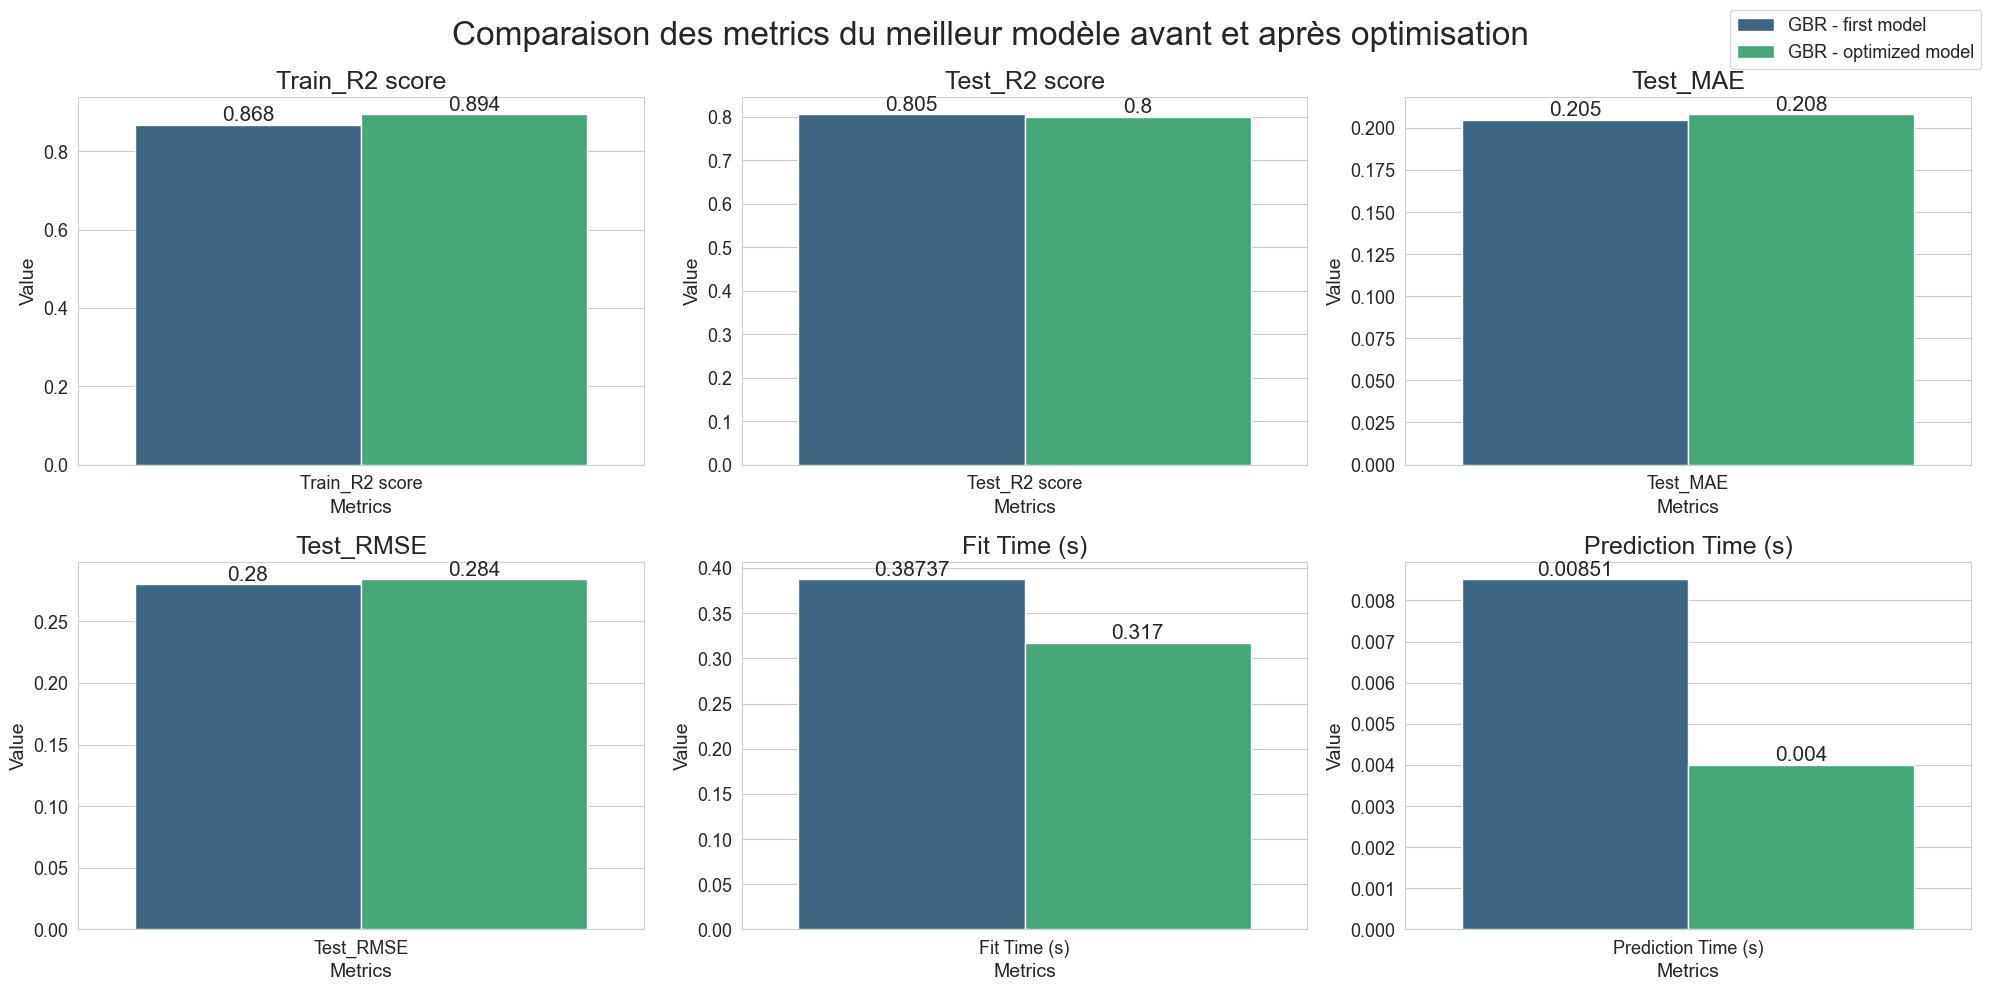

In [20]:
# Affichage de diagrammes à barres pour comparer le modèle avant et après optimisation
plot_metrics_comparison(eval_gbr, 
                        'Model', 
                        'Comparaison des metrics du meilleur modèle avant et après optimisation', 
                        legend_bbox_to_anchor=(1, 1))

In [21]:
# Enregistrement des meilleurs paramètres
pickle.dump(gbr_best_params, open('gbr_best_params_CO2.pkl', 'wb'))

## <font color='#46abe6'>3.2. Analyse des résidus<a class="anchor" id="3_2"></a></font>

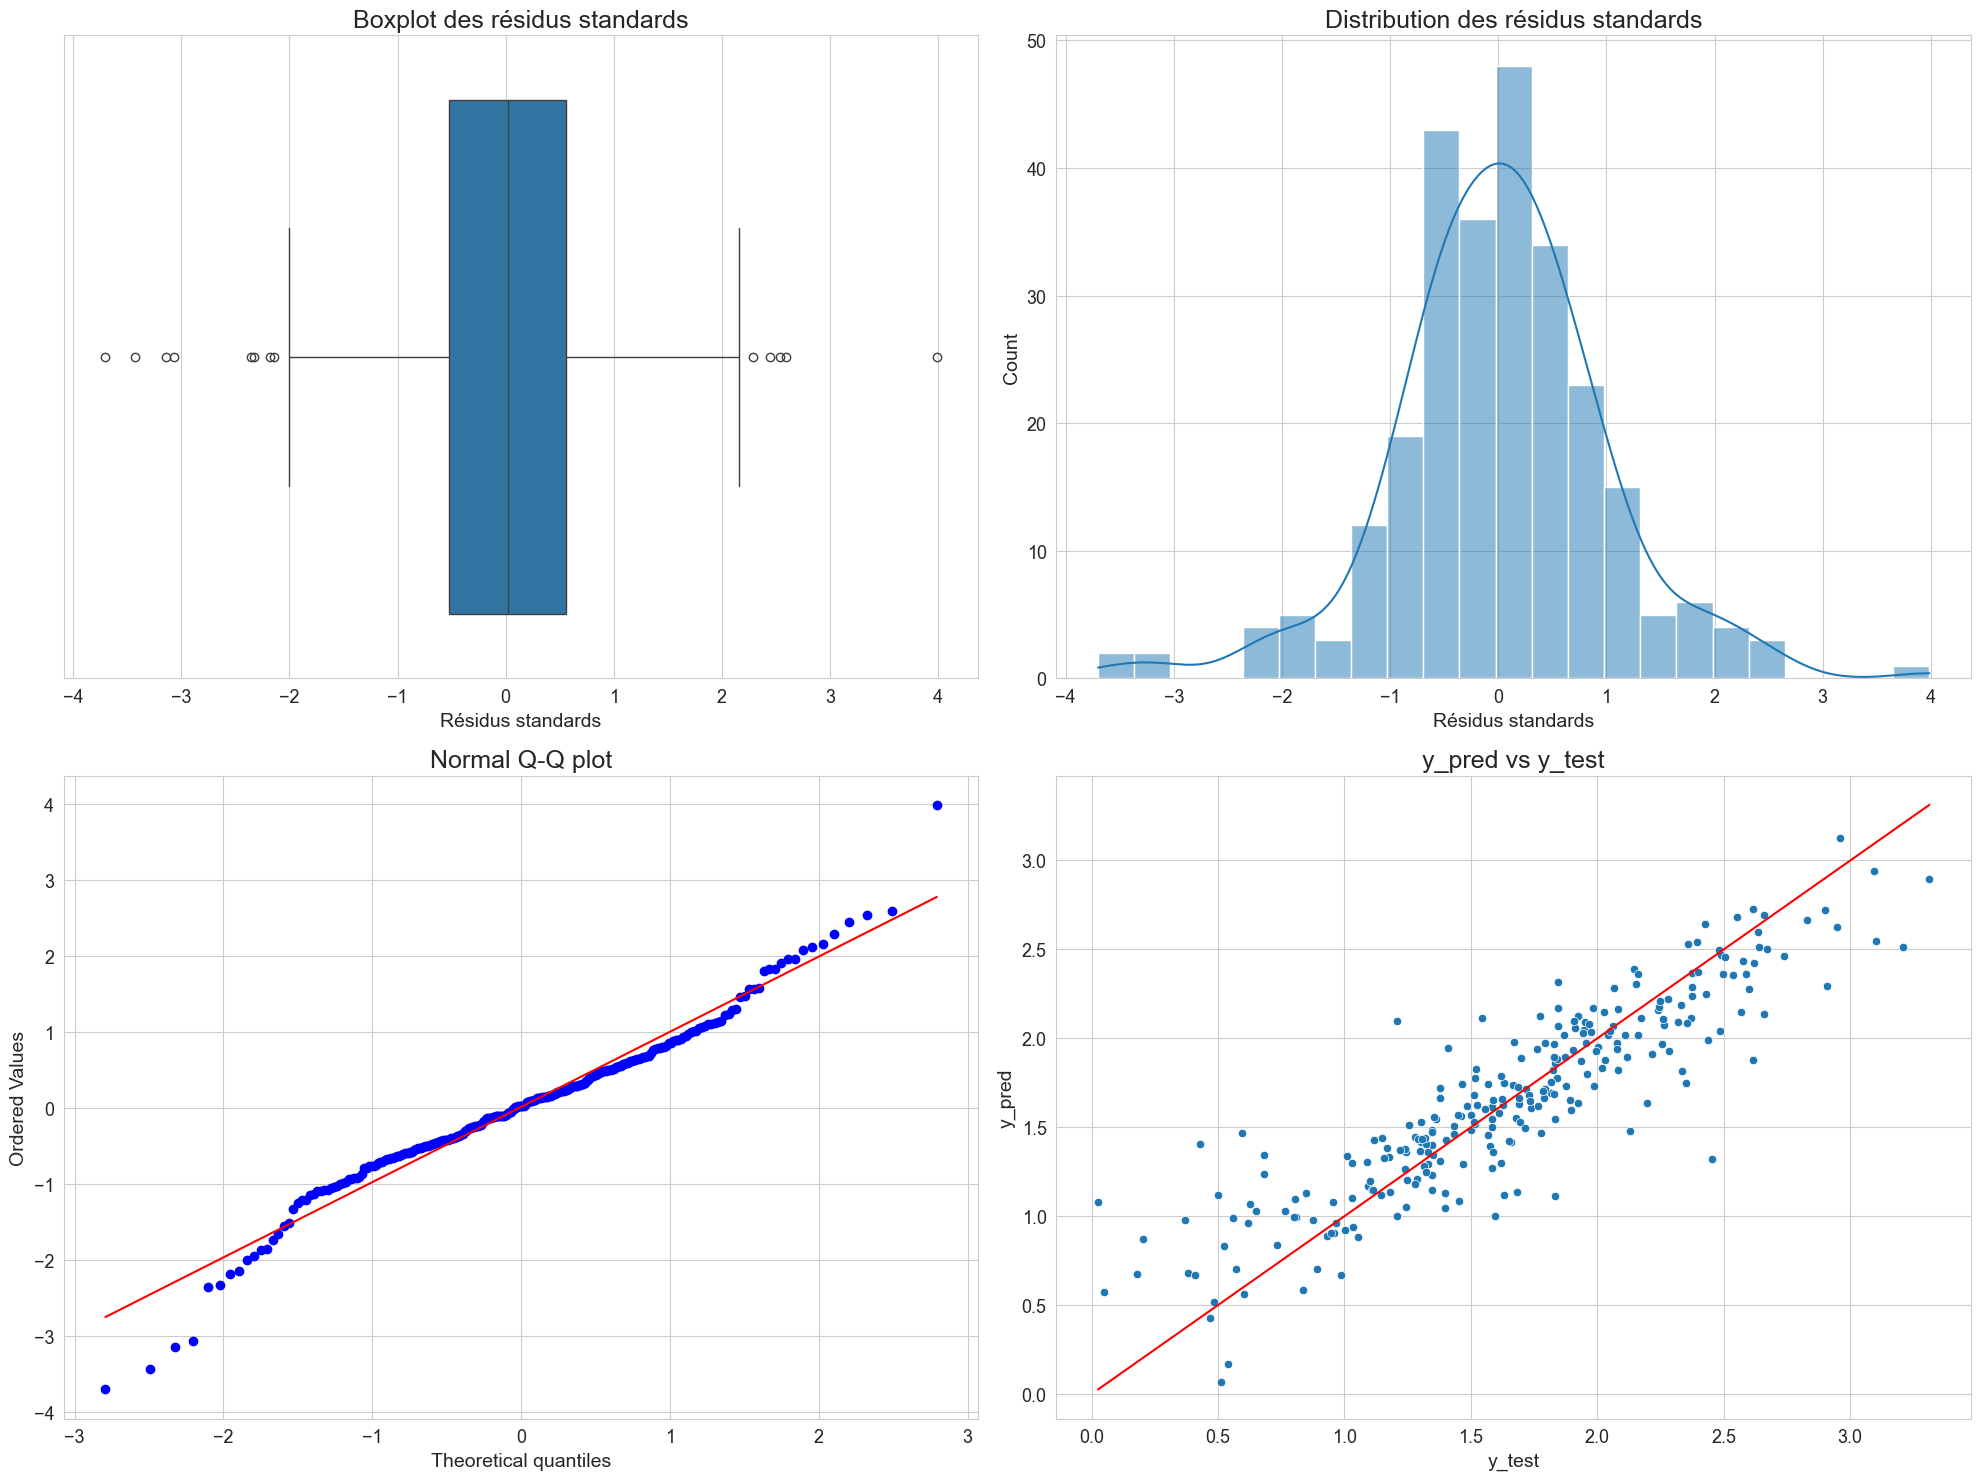

In [22]:
# Affichage des graphiques des résidus
plot_residuals_distribution(y_test, gbr_y_pred)

In [23]:
# test de normalité de Shapiro-Wilk
gbr_residual = y_test - gbr_y_pred

k2, p = st.shapiro(gbr_residual)
alpha = 0.05
print("p = ",p)
if p < alpha:  # H0 : la variable suit la loi normale de distribution
    print("H0 peut être rejetée : la distribution ne suit pas la loi normale.")
else:
    print("H0 est acceptée : la distribution suit la loi normale")

p =  1.70661551237572e-05
H0 peut être rejetée : la distribution ne suit pas la loi normale.


Test de Shapiro-Wilk : p-value < 0.05, l'hypothèse de normalité des résidus est rejetée. 
Cependant
- distribution très porche de la symétrie
- échantillon de taille suffisante (supérieure à 30) 
=> la distribution des résidus peut être considérée comme suivant une loi normale.

# <font color='#0a389f'>Partie 4 - Feature importance globale et locale<a class="anchor" id="partie4"></a></font>

Pour réaliser l'analyse des features importances globales et locales, la librairie utilisée ici est SHAP. Cette librairie utilise la valeur SHapley Additive exPlanation proposée par par S. Lundberg. La valeur de Shapley provient de la théorie des jeux. L’idée est de moyenner l’impact qu’une variable a pour toutes les combinaisons de variables possibles.

Le modèle retenu étant basé sur apprenants faibles de type arbre de décision, nous utiliserons l'algorithme appelé TreeExplainer, optimisé pour les arbres de décision et ensembles d’arbres.

In [24]:
# Preprocessing pour X_test
preprocessor = create_preprocessor(encoder, scaler, num_col, cat_col)

# Fit sur X_train
X_train_transformed = preprocessor.fit_transform(X_train)

# Transformer X_test
X_test_transformed = preprocessor.transform(X_test).toarray()

In [25]:
# Extraire le modèle final du pipeline
final_model = best_gbr.named_steps['gradientboostingregressor']

In [26]:
# Feature importance locale
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_transformed)
local_feature_importance = shap_values

## <font color='#46abe6'>4.1. Feature importance globale<a class="anchor" id="4_1"></a></font>

In [27]:
# Feature importance globale
global_feature_importance = final_model.feature_importances_

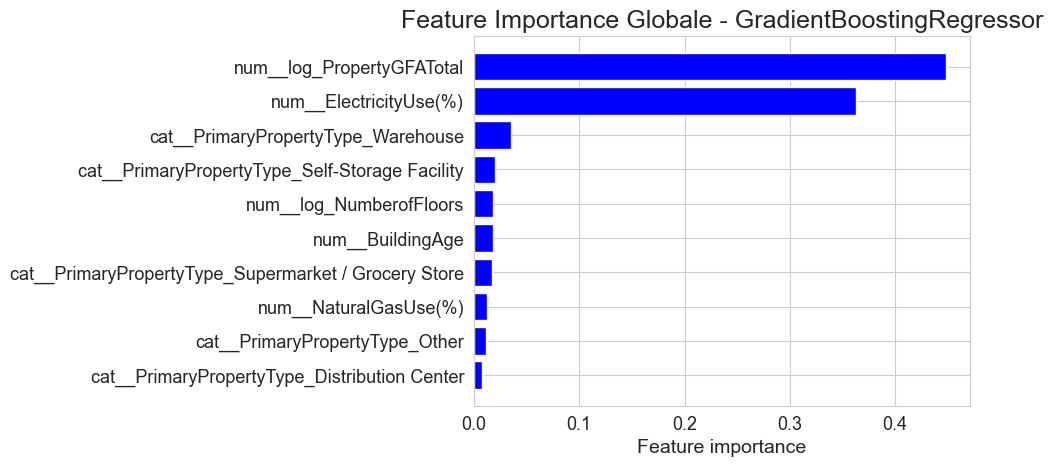

In [28]:
# Affichage du top 10 des features par importance
top_x = 10
indices = np.argsort(global_feature_importance)
indices = indices[-top_x:]

plt.barh(range(len(indices)), global_feature_importance[indices], color='b', align='center') 
plt.title('Feature Importance Globale - GradientBoostingRegressor')
plt.yticks(range(len(indices)), [preprocessor.get_feature_names_out()[i] for i in indices]) 
plt.xlabel('Feature importance')
plt.show()

Les features globales les plus importantes sont :
- log_PropertyGFATotal : la surface totale du bien qui a la contribution la plus forte sur la prédiction. 
- ElectricityUse(%) : la deuxième feature la plus importante
Nous retrouvons 5 types d'usage du bâtiment parmi les 10 variables les plus importantes.

* **Summary plot**

Le summary plot montre la distribution des valeurs SHAP de l'échantillon de test pour toutes les variables. Il montre également le lien entre les valeurs des variables et leurs contributions. 

Dans notre cas, nous observons :
- ElectricityUse(%) : un fort pourcentage d'électricité comme source d'énergie fait diminuer les émissions de CO2.
- PropertyGFATotal contribue fortement à la prédiction soit positivement, soit négativement en fonction des données.
- PrimaryPropertyType_Warehouse contribue marjoritairement négativement, ce qui est logique : un entreprot a une émission de CO2 plus faible.
- NaturalGasUse(%) : un fort pourcentage d'utilisation de Gas naturel comme source d'énergie fait augmenter les émissions de CO2.
- BuildingAge : ne permet pas de bien séparer les données, un BuildingAge élevé peut conduire avec une contribution positive ou négative. Le fait d'avoir la construction du bâtiment et la dernière rénovation du bâtiment dans cette feature n'est pas pertinent ici.
- NumberOfFloors ne permet pas également de bien séparer les données.

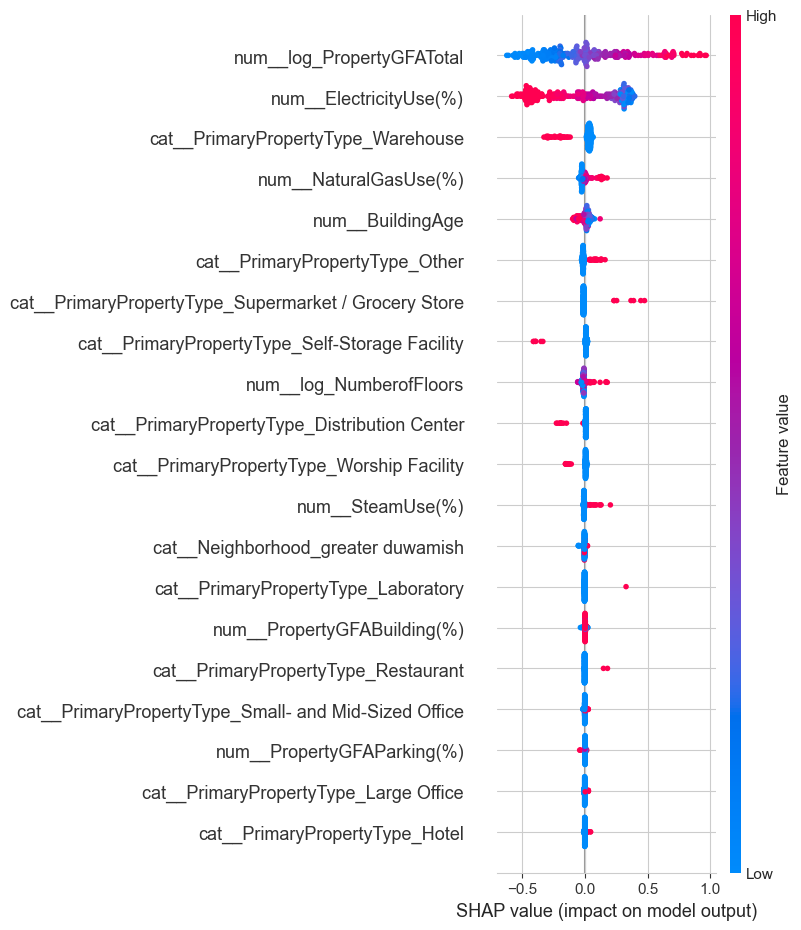

In [29]:
shap.summary_plot(explainer.shap_values(X_test_transformed),
                  features = X_test_transformed,
                  feature_names=preprocessor.get_feature_names_out())

## <font color='#46abe6'>4.2. Feature importance locale<a class="anchor" id="4_2"></a></font>

Le force plot montre les contributions des valeurs SHAP dans la génération de la prédiction finale en utilisant une disposition de force additive. Il montre quelles caractéristiques ont contribué positivement ou négativement à la valeur de base pour générer une prédiction.

* **Analyse d'un élément de la catégorie la plus fréquente 'Small- and Mid-Sized Office'**

In [30]:
index = 1811
loc = X_test.index.get_loc(index)
building_data.loc[index]

OSEBuildingID                                   23846
PrimaryPropertyType       Small- and Mid-Sized Office
Neighborhood                                 downtown
NumberofBuildings                                 1.0
NumberofFloors                                      3
PropertyGFATotal                                34030
SiteEnergyUse(kBtu)                       1748629.875
TotalGHGEmissions                               22.26
BuildingAge                                        37
PropertyGFAParking(%)                             0.0
PropertyGFABuilding(%)                            1.0
SteamUse(%)                                       0.0
ElectricityUse(%)                                0.88
NaturalGasUse(%)                                 0.12
Name: 1811, dtype: object

Pour cet élément, les features qui influent le plus sur la prédiction sont : log_PropertyGFATotal et ElectricityUse(%) en négatif.

In [31]:
# force plot
shap.force_plot(explainer.expected_value, 
                explainer.shap_values(X_test_transformed[loc]), 
                X_test_transformed[loc], 
                feature_names=preprocessor.get_feature_names_out(),
                out_names="log_TotalGHGEmissions")

* **Analyse d'un élément de la catégorie la moins fréquente 'Laboratory'**

In [32]:
index = 333
loc = X_test.index.get_loc(index)
building_data.loc[index]

OSEBuildingID                    469
PrimaryPropertyType       Laboratory
Neighborhood              lake union
NumberofBuildings                1.0
NumberofFloors                     3
PropertyGFATotal               55200
SiteEnergyUse(kBtu)       11594121.0
TotalGHGEmissions             269.71
BuildingAge                       88
PropertyGFAParking(%)            0.0
PropertyGFABuilding(%)           1.0
SteamUse(%)                      0.0
ElectricityUse(%)               0.65
NaturalGasUse(%)                0.35
Name: 333, dtype: object

Pour cet élément, les features qui influent le plus et façon négative sur la prédiction sont : log_PropertyGFATotal, BuildingAge et ELectricityUse(%).

In [33]:
# force plot
building_iloc = 69
shap.force_plot(explainer.expected_value, 
                explainer.shap_values(X_test_transformed[building_iloc]), 
                X_test_transformed[building_iloc], 
                feature_names=preprocessor.get_feature_names_out(),
                out_names="log_TotalGHGEmissions")

* **Analyse d'un outlier identifié dans l'analyse exploratoire**

In [34]:
# Outlier pour TotalGHGEmissions
index = 119
loc = X_test.index.get_loc(index)
building_data.loc[index]

OSEBuildingID                    338
PrimaryPropertyType            Other
Neighborhood                downtown
NumberofBuildings                1.0
NumberofFloors                    11
PropertyGFATotal              299070
SiteEnergyUse(kBtu)       65336980.0
TotalGHGEmissions            2055.82
BuildingAge                       12
PropertyGFAParking(%)           0.23
PropertyGFABuilding(%)          0.77
SteamUse(%)                      0.0
ElectricityUse(%)               0.47
NaturalGasUse(%)                0.53
Name: 119, dtype: object

Pour cet outlier, les features qui influent le plus et de façon positive sur la prédiction sont : log_PropertyGFATotal et ElectricityUse(%).

In [35]:
shap.force_plot(explainer.expected_value, 
                explainer.shap_values(X_test_transformed[loc]), 
                X_test_transformed[building_iloc], 
                feature_names=preprocessor.get_feature_names_out(),
                out_names="log_TotalGHGEmissions")

## <font color='#46abe6'>4.3. Conclusion<a class="anchor" id="4_3"></a></font>

* Les catégories `PrimaryPropertyType` pourraient être remplacées par l'utilisation de `LargestPropertyUseType`, `SecondLargestPropertyUseType`, `ThirdLargestPropertyUseType` avec l'information du pourcentage d'utilisation de chaque property use.

* Les catégories de `Neighborhood` ont des contributions proches 0 : d'autres variables géographiques pourraient être testés.

* La feature BuildingAge pourrait être scindée en 2 : construction du bâtiment et dernière rénovation.